In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import itertools as itt

# Первичный отсмотр данных

In [2]:
pd.set_option('display.max_rows', 400) # показывать больше строк
pd.set_option('display.max_columns', 400) # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

display(stud.head(3)) # Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов
#display(stud)
stud.info()

#display(stud.duplicated()) # проверка на повторы

Tabl={'school': 'аббревиатура школы, в которой учится ученик',
'sex': 'пол ученика', 
'age': 'возраст ученика', 
'address': 'тип адреса ученика (U - городской, R - за городом)',
'famsize': 'размер семьи (LE3 <= 3, GT3 >3)', 
'Pstatus': 'статус совместного жилья родителей (T - живут вместе A - раздельно)', 
'Medu': 'образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)', 
'Fedu': 'образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)',
'Mjob': 'работа матери (teacher - учитель, health - сфера здравоохранения, services - гос служба, at_home - не работает, other - другое)',
'Fjob': 'работа отца (teacher - учитель, health - сфера здравоохранения, services - гос служба, at_home - не работает, other - другое)',
'reason': 'причина выбора школы (home - близость к дому, reputation - репутация школы, course - образовательная программа, other - другое)',
'guardian': 'опекун (mother - мать, father - отец, other - другое)',
'traveltime': 'время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)',
'studytime': 'время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)',
'failures': 'количество внеучебных неудач (n, если 1<=n<=3, иначе 0)',
'schoolsup': 'дополнительная образовательная поддержка (yes или no)',
'famsup': 'семейная образовательная поддержка (yes или no)',
'paid': 'дополнительные платные занятия по математике (yes или no)',
'activities': 'дополнительные внеучебные занятия (yes или no)',
'nursery': 'посещал детский сад (yes или no)',
'higher': 'хочет получить высшее образование (yes или no)',
'internet': 'наличие интернета дома (yes или no)',
'romantic': 'в романтических отношениях (yes или no)',
'famrel': 'семейные отношения (от 1 - очень плохо до 5 - очень хорошо)',
'freetime': 'свободное время после школы (от 1 - очень мало до 5 - очень мого)',
'goout': 'проведение времени с друзьями (от 1 - очень мало до 5 - очень много)',
'health': 'текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)',
'absences': 'количество пропущенных занятий',
'score': 'баллы по госэкзамену по математике'}

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

# Предобработка

In [3]:
def iskl_prop(a):  # замена пропущенный значений на 'None' или '-1'
    stud[a] = stud[a].apply(lambda x: 'None' if (pd.isnull(x)) & (stud[a].dtype == 'object') else
                            -1.0 if (pd.isnull(x)) & (stud[a].dtype == 'float64') else x)


def graf(n, m, a, b, c):  # построение графика формирование подрисуночной надписи
    fig = plt.figure()
    axes = fig.add_axes([0, 0, n, m])
    axes.set_title(str(a))
    axes.set_xlabel(b)
    axes.set_ylabel(c)


# построение группы графиков hist формирование подрисуночной надписи
def graf_gryp(s, n, m, nn, mm, st, a, b, c):
    k1 = 0
    k2 = 0
    fig, axes = plt.subplots(n, m, figsize=(nn, mm))
    for i in s.columns:
        if (Value[Tabl[i]] > a) & (Value[Tabl[i]] < b):
            axes[k1, k2].hist(s[i], color=str(c), bins=st)
            axes[k1, k2].set_title(str(Tabl[i][:Tabl[i].find('(')]))
            axes[n-1, k2].set_xlabel('Значения')
            axes[k1, 0].set_ylabel('Кол-во')
            if k2 > m-2:
                k1 += 1
                k2 = 0
            else:
                k2 += 1


def graf_boxplot(s, column):  # построение графика boxplot формирование подрисуночной надписи
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score', data=s, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + Tabl[i])
    plt.show()

# Первичный анализ данных

In [4]:
# исключение столбца, которого нет в описании
stud.drop(['studytime, granular'], inplace=True, axis=1)
display(stud.head(3))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0


<ipython-input-3-47ae5d072291>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


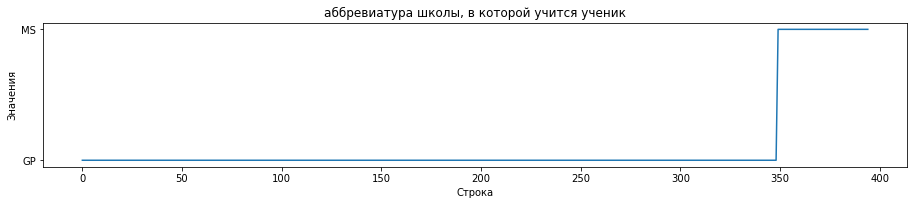

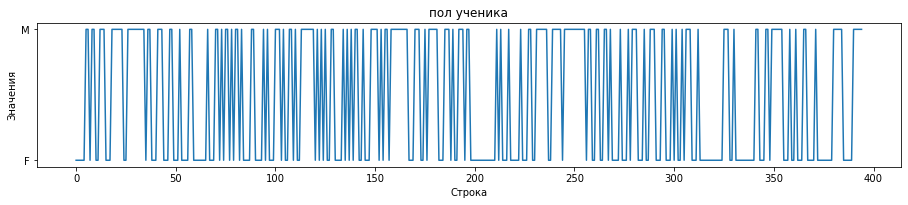

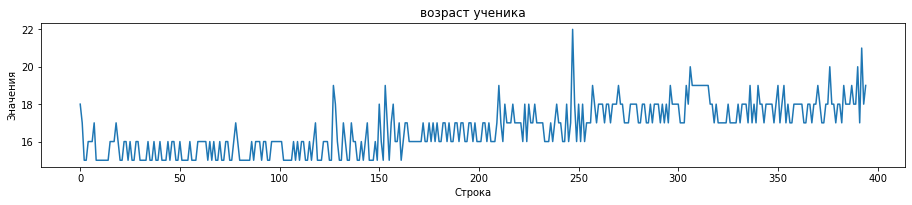

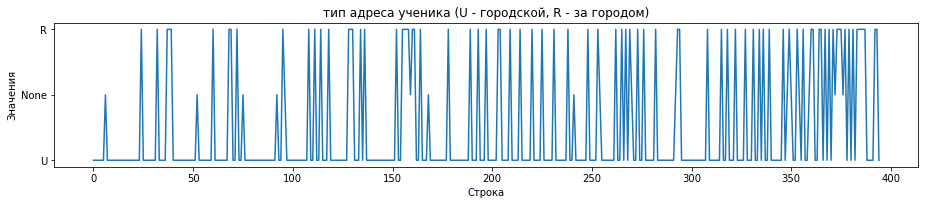

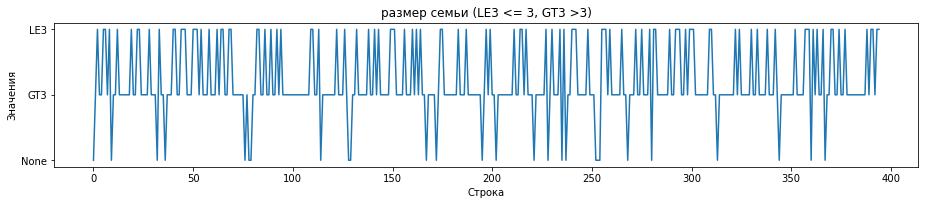

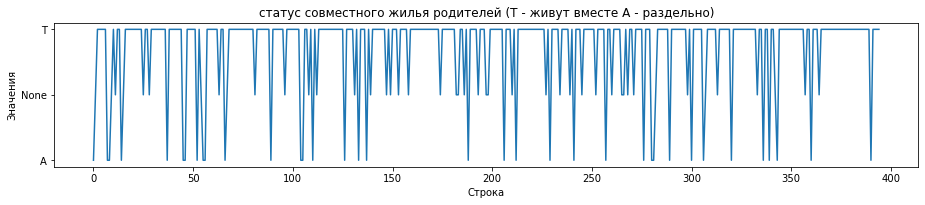

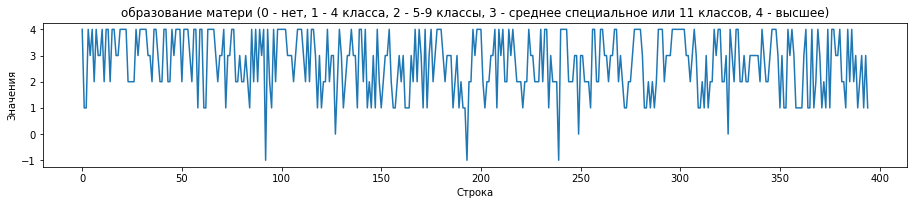

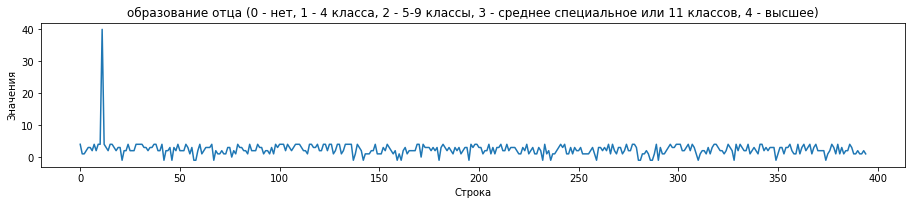

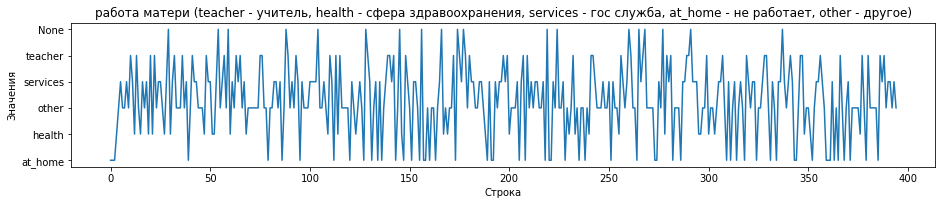

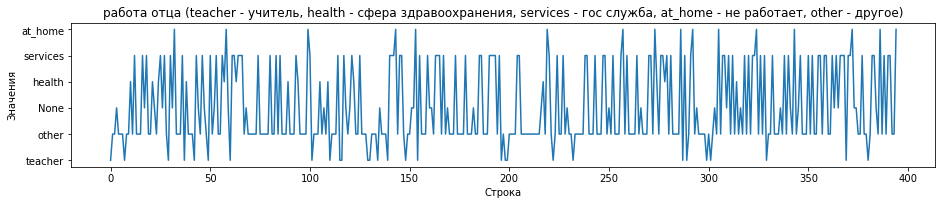

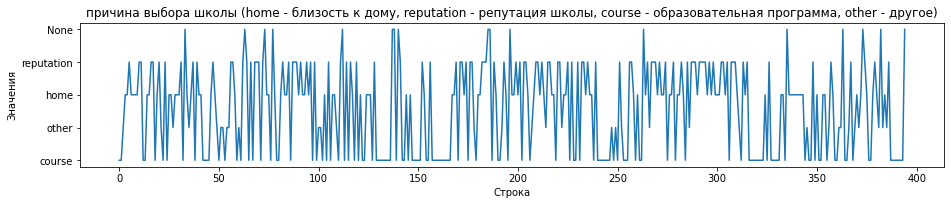

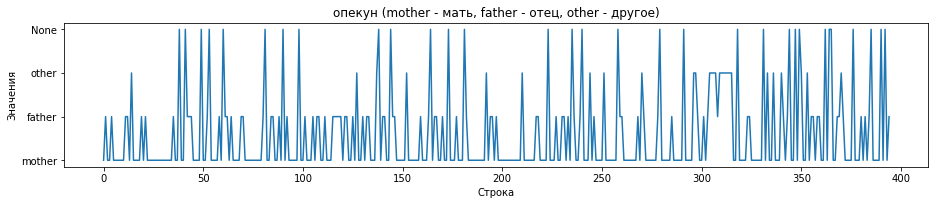

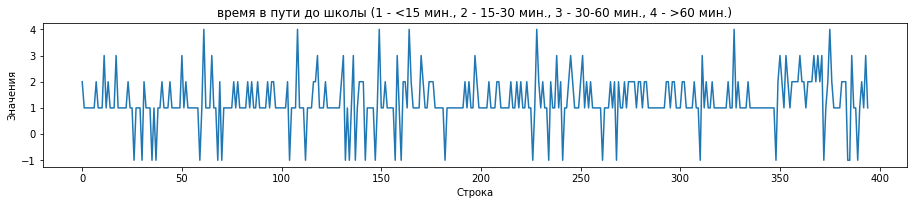

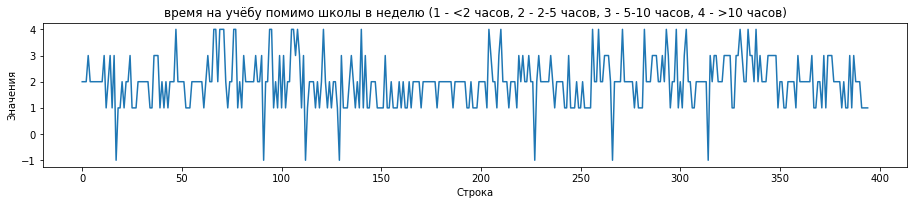

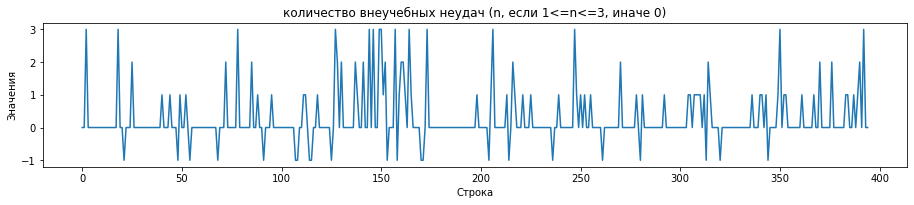

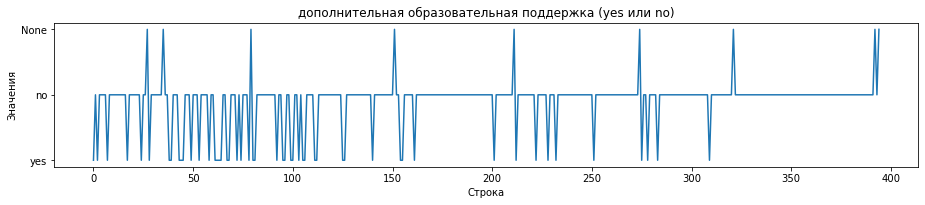

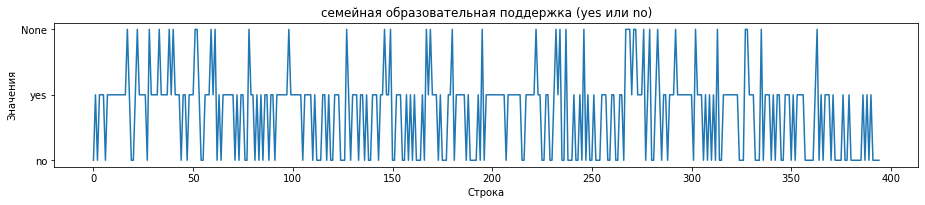

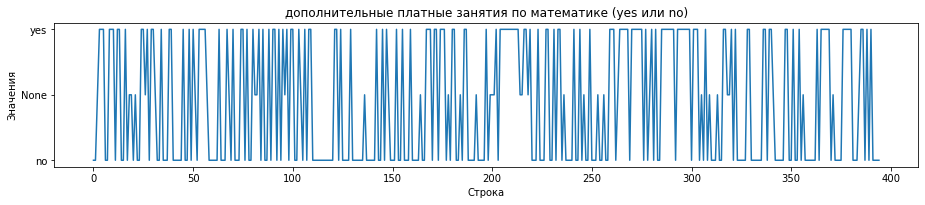

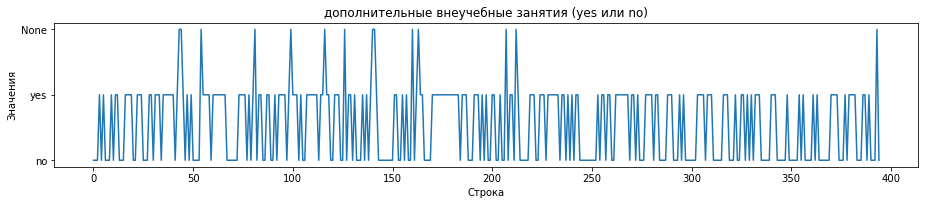

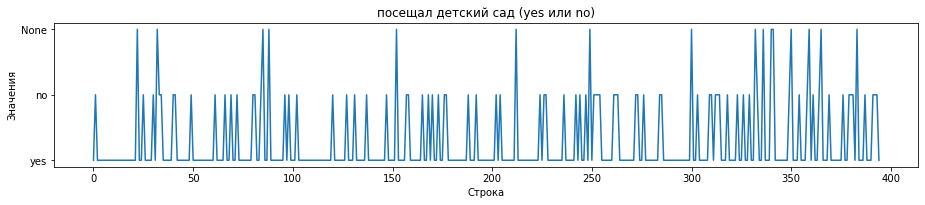

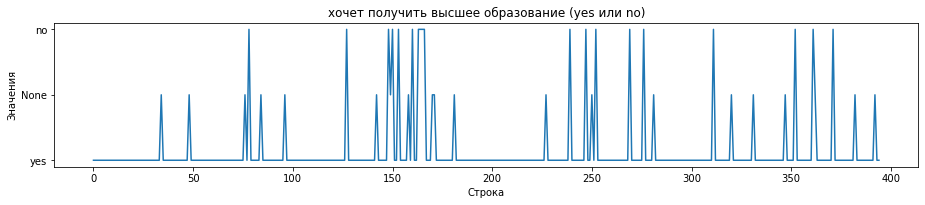

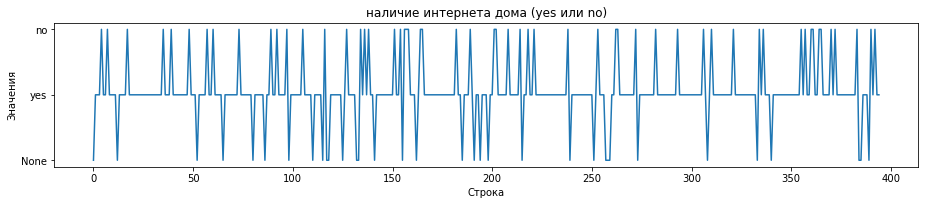

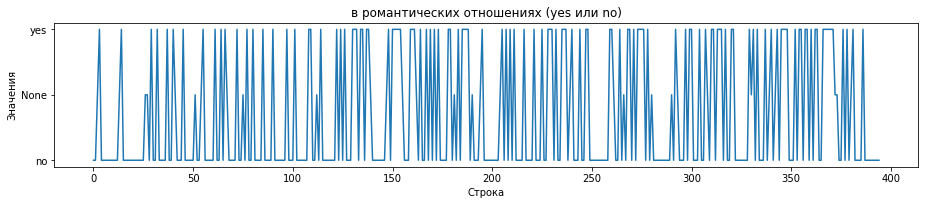

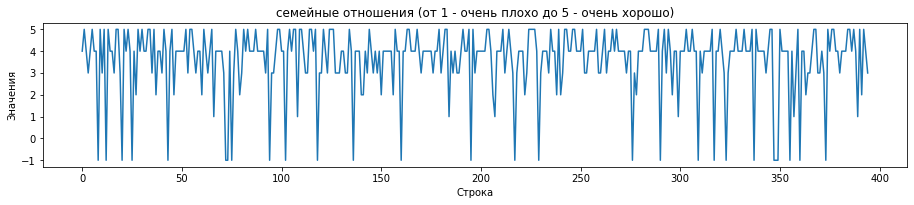

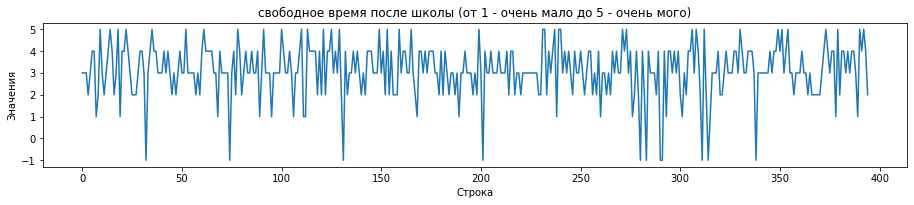

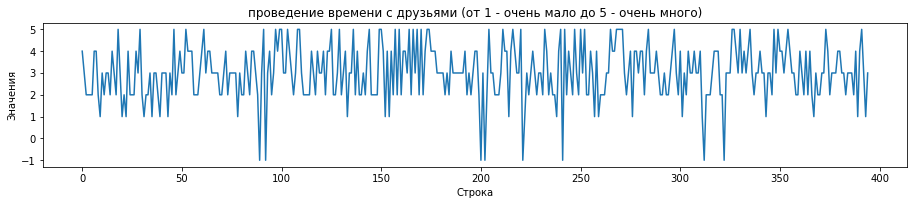

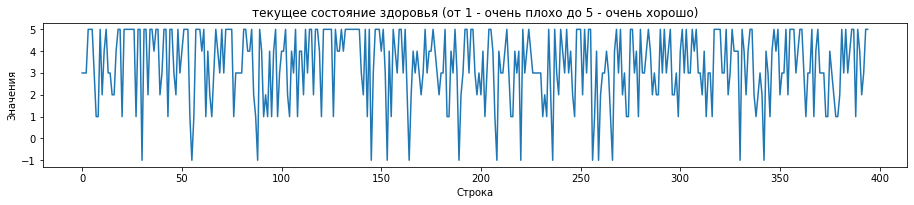

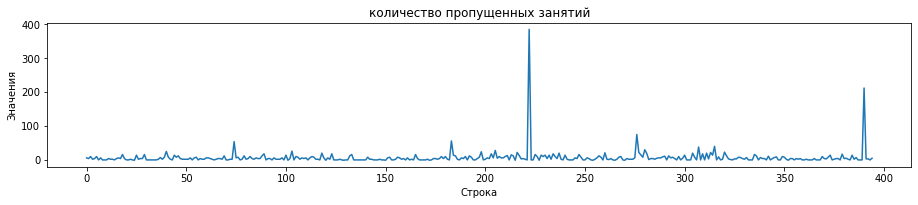

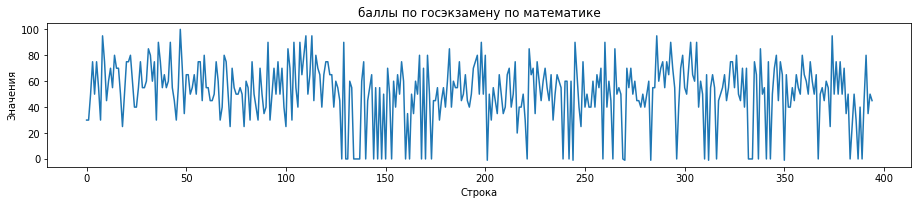

In [5]:
# визуализация типа и характера данных по строкам
Value={}
for i in stud.columns: 
    iskl_prop(i)
    Value[str(Tabl[i])]=stud[i].nunique()
    graf(2,0.5,Tabl[i],'Строка','Значения')
    plt.plot(stud[i])
#print(Value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      350 non-null    object 
 1   sex         350 non-null    object 
 2   age         350 non-null    int64  
 3   address     350 non-null    object 
 4   famsize     350 non-null    object 
 5   Pstatus     350 non-null    object 
 6   Medu        350 non-null    float64
 7   Fedu        350 non-null    float64
 8   Mjob        350 non-null    object 
 9   Fjob        350 non-null    object 
 10  reason      350 non-null    object 
 11  guardian    350 non-null    object 
 12  traveltime  350 non-null    float64
 13  studytime   350 non-null    float64
 14  failures    350 non-null    float64
 15  schoolsup   350 non-null    object 
 16  famsup      350 non-null    object 
 17  paid        350 non-null    object 
 18  activities  350 non-null    object 
 19  nursery     350 non-null    o

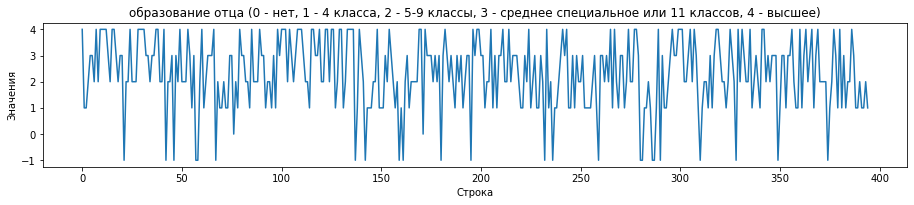

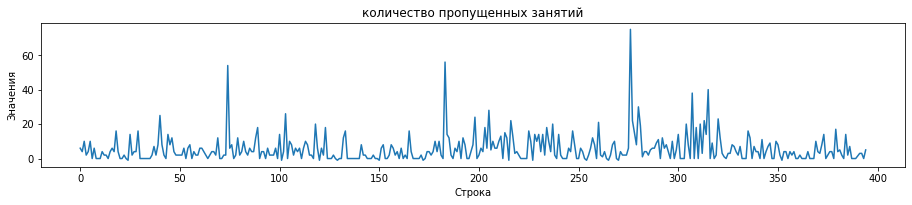

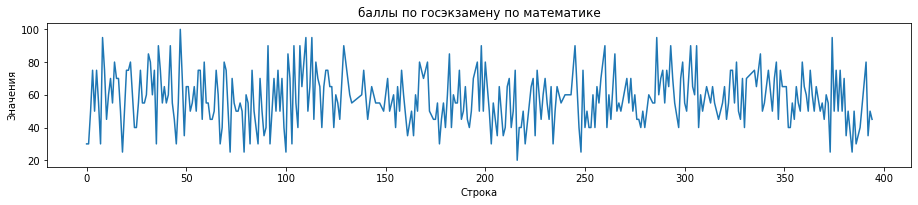

In [6]:
# судя по всему в колонке 'Fedu' опечатка - лишний "0"
stud['Fedu'] = stud['Fedu'].apply(lambda x: x/10 if x % 10 == 0 else x)
graf(2, 0.5, Tabl['Fedu'], 'Строка', 'Значения')
plt.plot(stud['Fedu'])

# исключаем 2-х прогульщиков
stud = stud[stud['absences'] < 100]
graf(2, 0.5, Tabl['absences'], 'Строка', 'Значения')
plt.plot(stud['absences'])

# исключаем тех, кто судя по всему ещё не сдавал экзамен
stud = stud[stud['score'] > 0]
graf(2, 0.5, Tabl['score'], 'Строка', 'Значения')
plt.plot(stud['score'])
stud.info()

возраст ученика count    350.000000
mean      16.625714
std        1.246162
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64
количество пропущенных занятий count    340.000000
mean       6.382353
std        8.323527
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       75.000000
Name: absences, dtype: float64
баллы по госэкзамену по математике count    350.000000
mean      57.714286
std       16.167234
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64


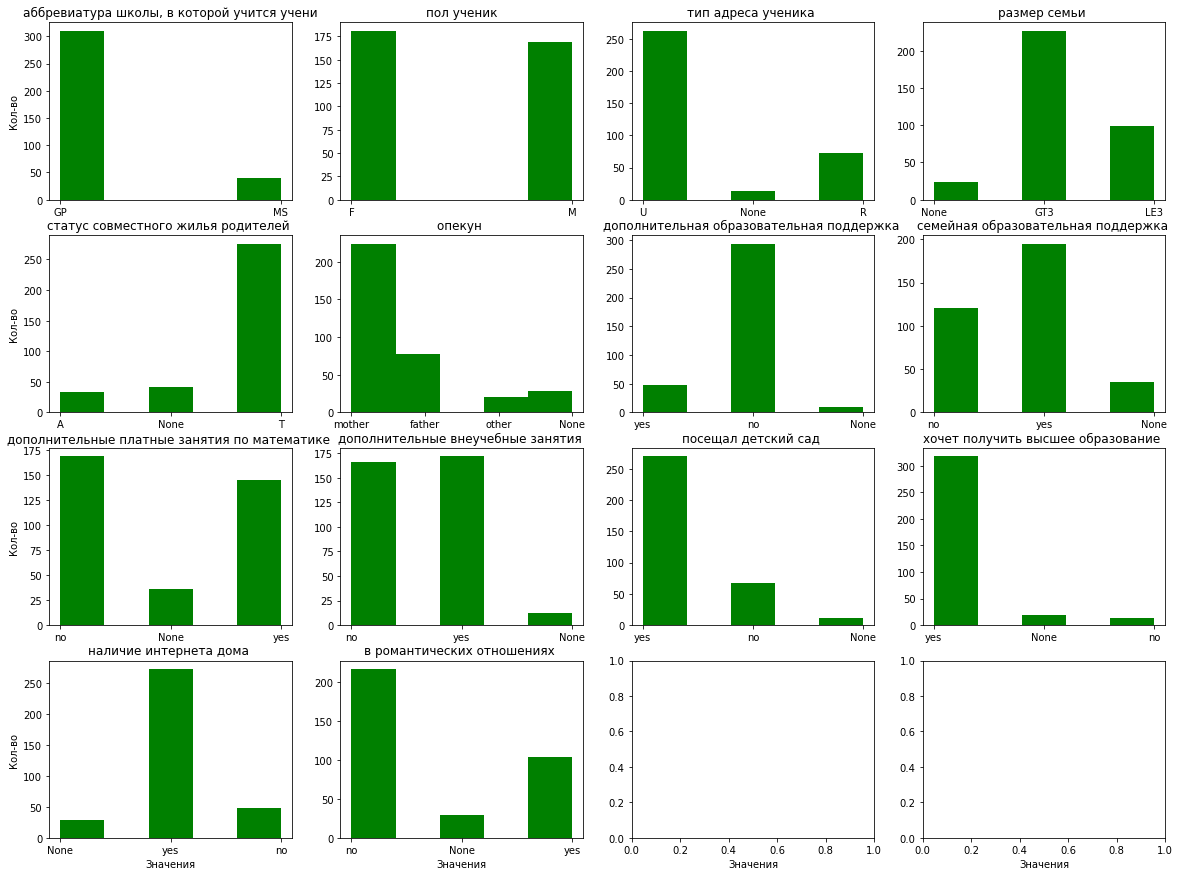

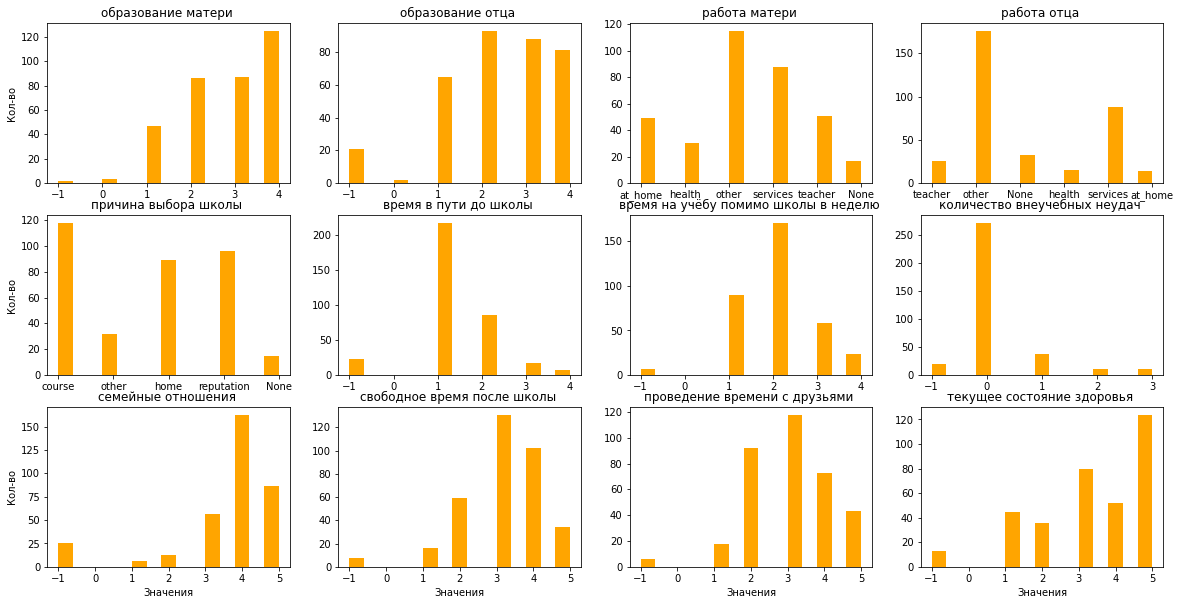

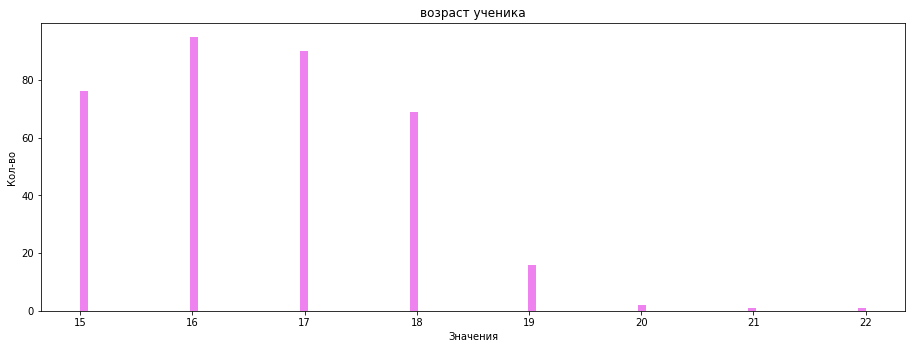

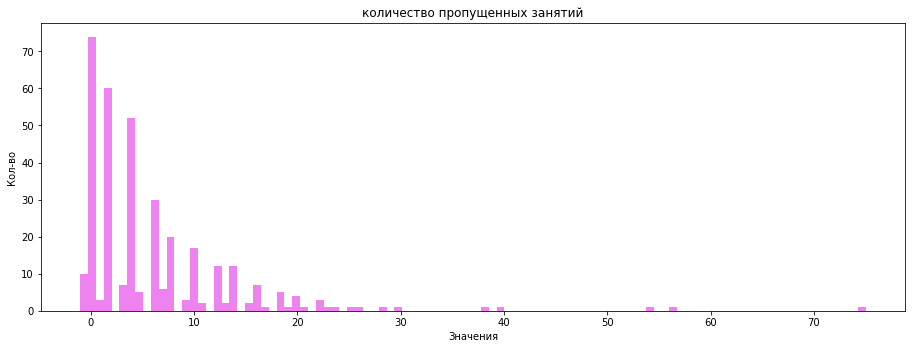

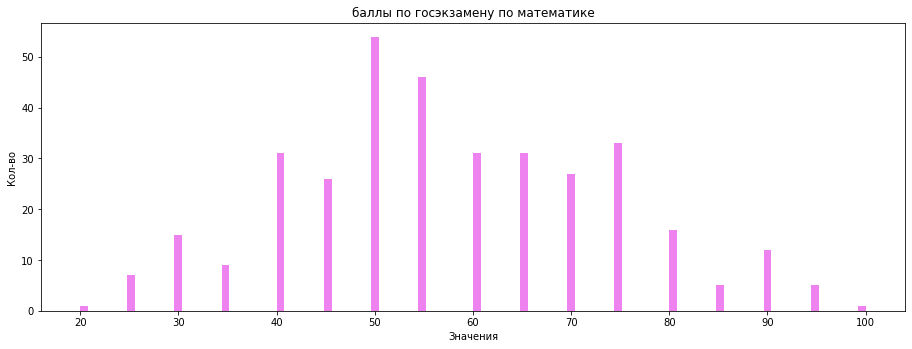

In [7]:
# визуализация распределения данных и кол-ва пропусков в солбцах по значениям 

graf_gryp(stud,4,4,20,15,5,1,5,'green') # анализ столбцов с данными, принимающими 2-3 значения (типа да/нет)
graf_gryp(stud,3,4,20,10,15,4,8,'orange') # анализ столбцов с данными, принимающими несколько значений 
                                            #(числа используются для обозначения групп характерных значений)
            
for i in stud.columns: # анализ столбцов с числовыми данными
    if (Value[Tabl[i]]>7)&(Value[Tabl[i]]<100):
        kol_now=stud[i] # значения текущей колонки 
        kol_now=kol_now[kol_now>-0.1] # значения текущей колонки без пропусков
        print(Tabl[i],kol_now.describe()) # сводная статистика для столбцов с численными данными
        graf(2,1,Tabl[i],'Значения','Кол-во')
        plt.hist(stud[i],color='violet',bins=100)   
        

<ipython-input-3-47ae5d072291>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


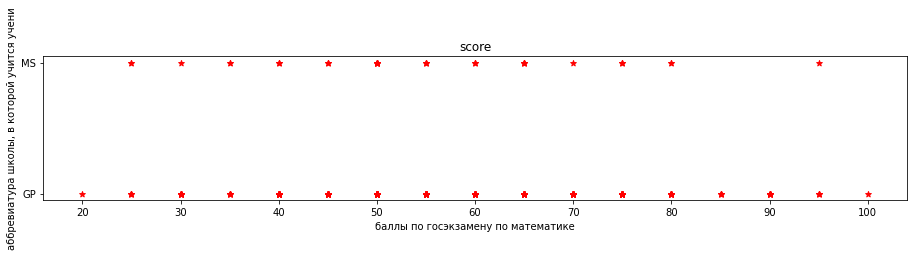

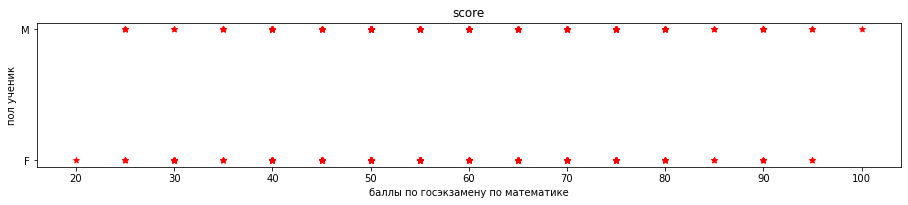

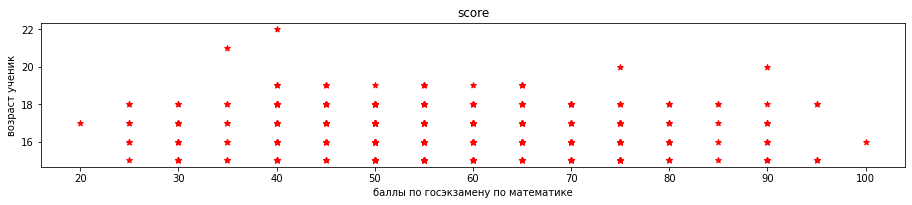

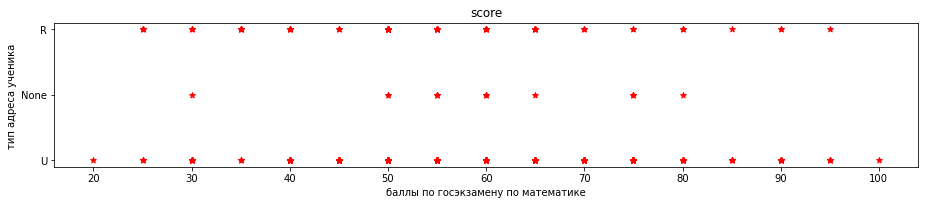

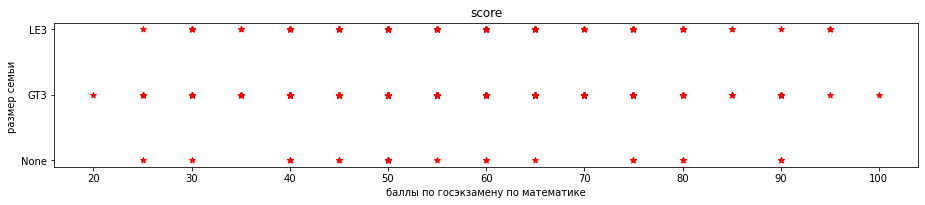

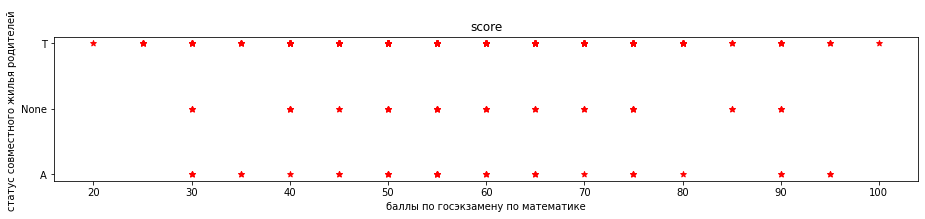

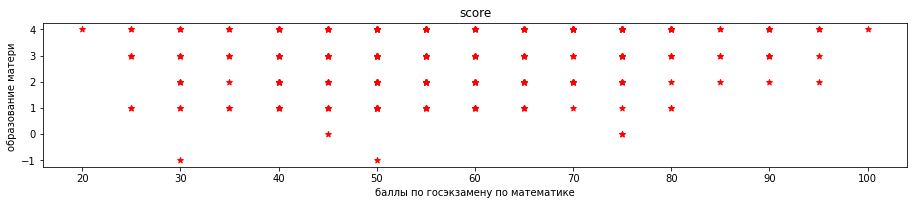

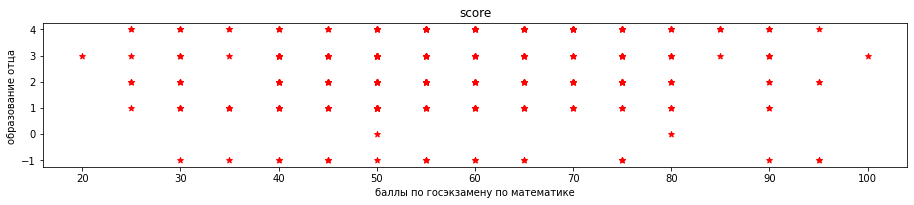

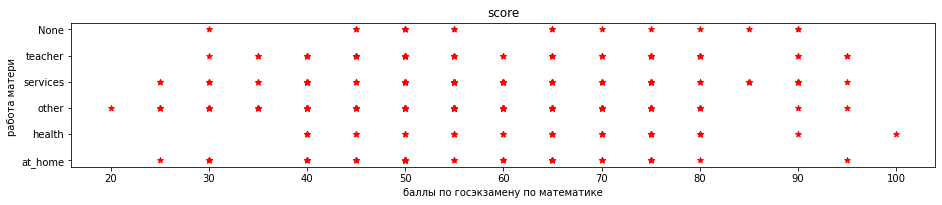

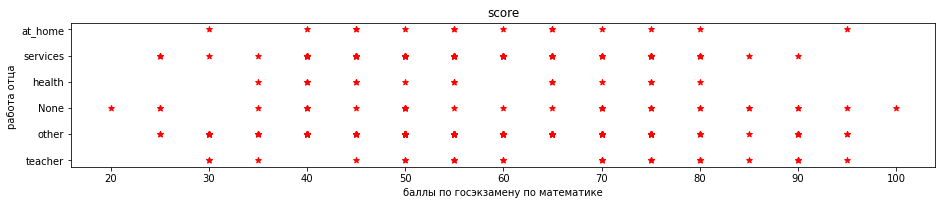

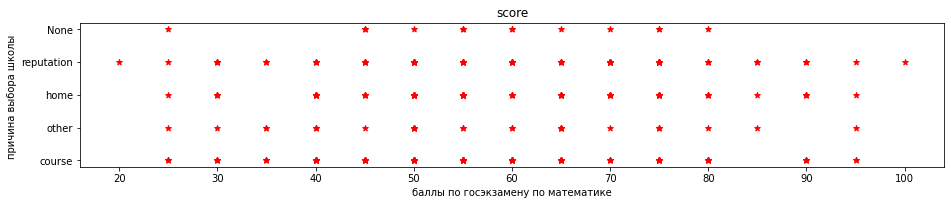

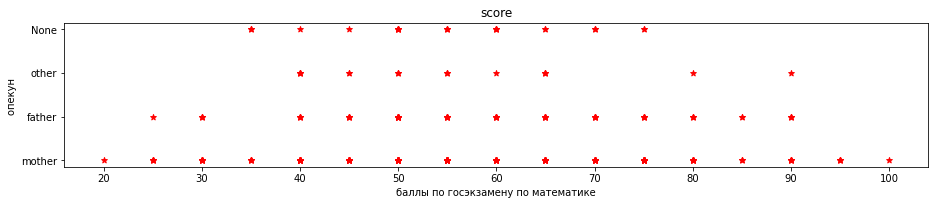

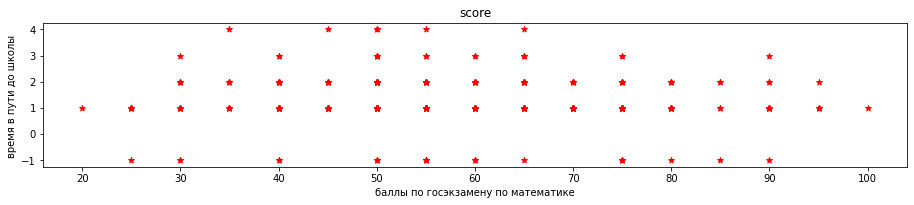

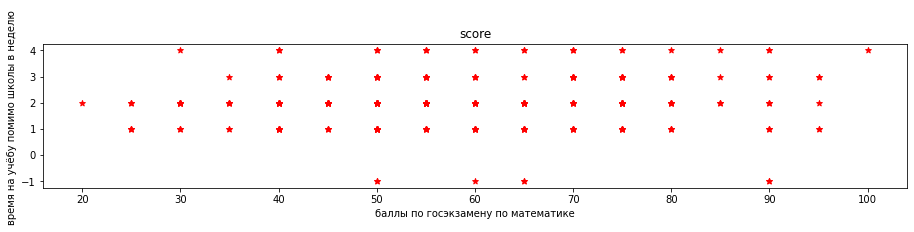

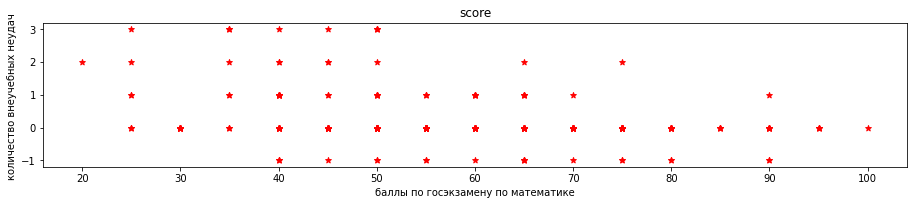

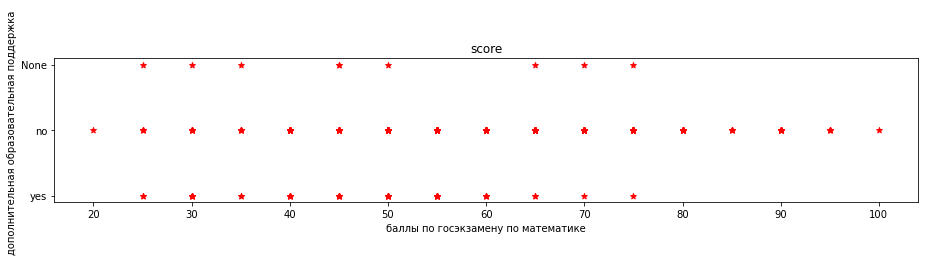

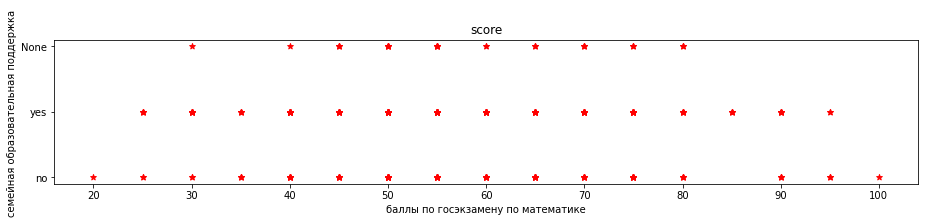

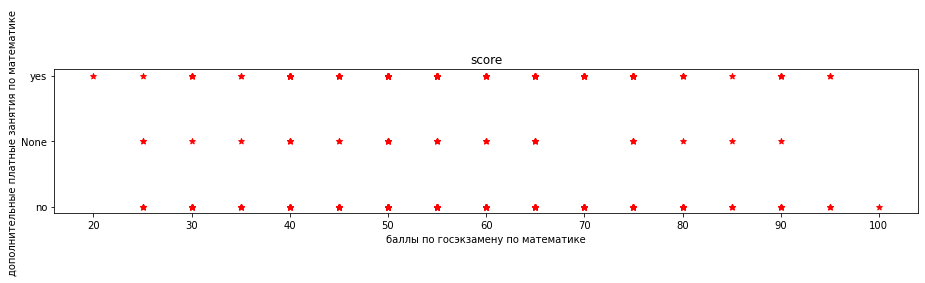

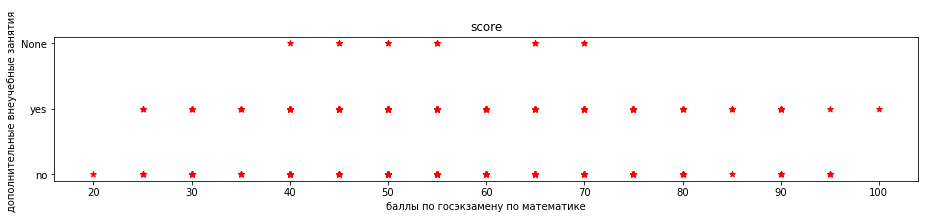

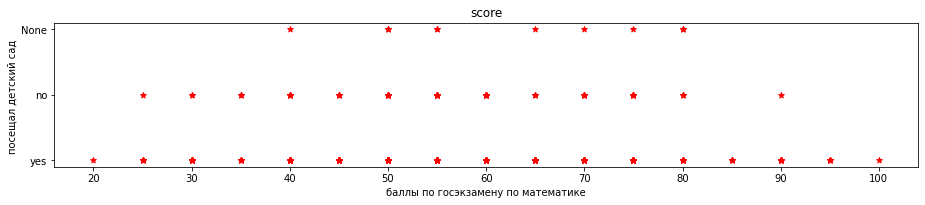

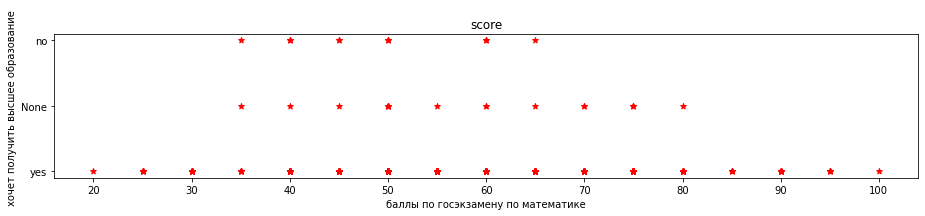

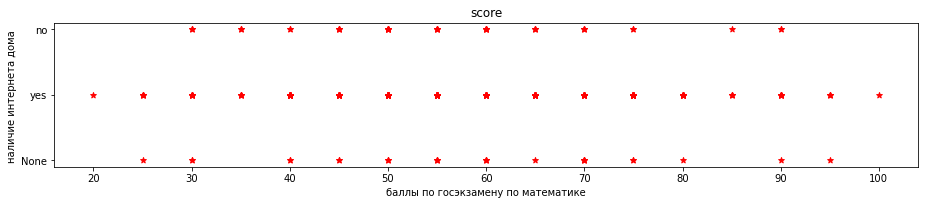

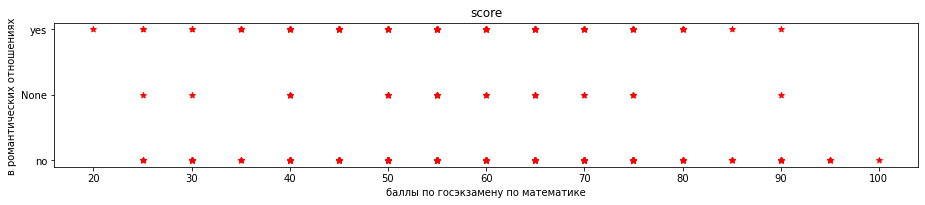

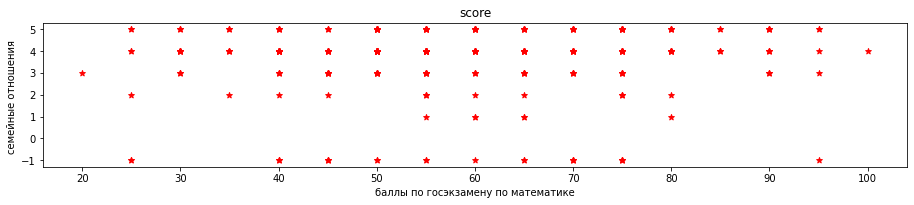

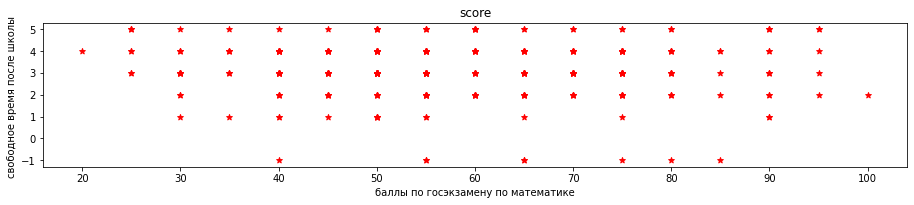

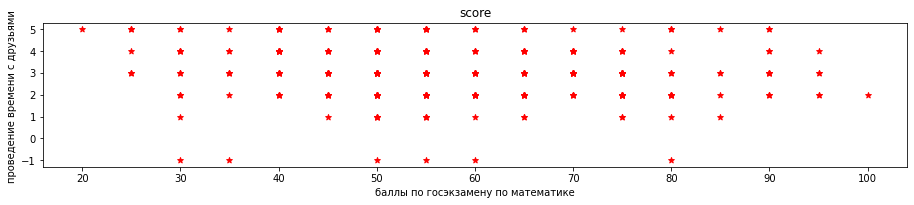

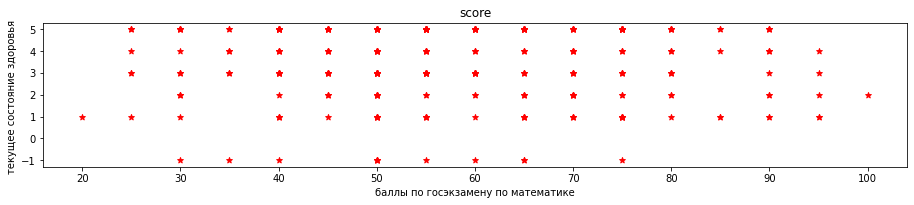

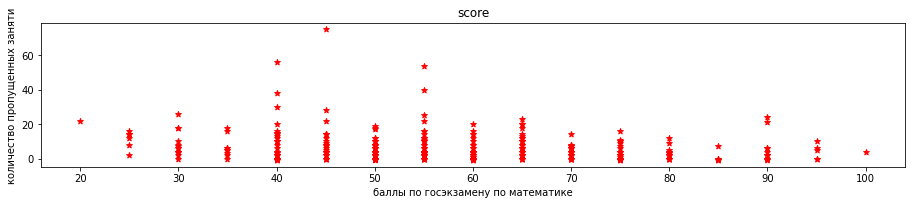

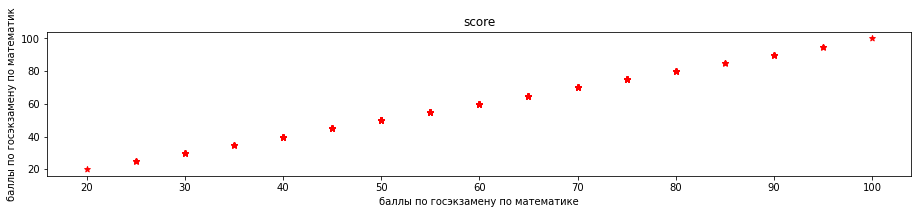

In [8]:
# распределение значений столбцов по 'score'
for i in stud.columns: # 
    graf(2,0.5,'score',Tabl['score'],Tabl[i][:Tabl[i].find('(')]) 
    plt.scatter(x = stud['score'], y = stud[i], marker = '*', color = 'red')
    

# Корреляционный анализ численных значений

In [9]:
col=[]
stud_kor = pd.DataFrame()
stud_kor_bp = pd.DataFrame()
for i in stud.columns:
    if (stud[i].dtype!='object'):
        col.append(i)
        stud_kor[i]=stud[i] # формирование табл. с сравниваемыми характеристиками
        stud_kor_bp[i]=stud[i]
        stud_kor_bp=stud_kor_bp[stud_kor_bp[i]>-0.1] # удаление пропусков
#print(col)
kor2=list(itt.combinations(col,2))
#print(kor2)
for i,j in kor2:
    stud_kor2 = pd.DataFrame() # формирование табл. с 2 сравниваемыми характеристиками
    stud_kor2[i]=stud[i]
    stud_kor2[j]=stud[j]
    stud_kor2=stud_kor[stud_kor[i]>-0.1] # удаление пропусков
    stud_kor2=stud_kor[stud_kor[j]>-0.1] # если рассматривать одновременно 2 хар-ки можно оставить для анализа больше строк
    if (i=='score')|(j=='score'):
        print(i,'-',j,'Kor:',round(stud_kor2.corr()[i][j],3), end='\n\n')
    else:
        print(i,'-',j,'Kor:',round(stud_kor2.corr()[i][j],3))

#sns.pairplot(stud_kor, kind = 'reg')
#display(stud_kor.corr())
#sns.pairplot(stud_kor, kind = 'reg')
#display(stud_kor_bp.corr())

age - Medu Kor: -0.12
age - Fedu Kor: -0.127
age - traveltime Kor: 0.101
age - studytime Kor: -0.011
age - failures Kor: 0.219
age - famrel Kor: 0.057
age - freetime Kor: -0.01
age - goout Kor: 0.116
age - health Kor: -0.06
age - absences Kor: 0.211
age - score Kor: -0.125

Medu - Fedu Kor: 0.595
Medu - traveltime Kor: -0.15
Medu - studytime Kor: 0.081
Medu - failures Kor: -0.188
Medu - famrel Kor: -0.005
Medu - freetime Kor: 0.028
Medu - goout Kor: 0.087
Medu - health Kor: -0.036
Medu - absences Kor: 0.072
Medu - score Kor: 0.204

Fedu - traveltime Kor: -0.058
Fedu - studytime Kor: -0.027
Fedu - failures Kor: -0.211
Fedu - famrel Kor: -0.011
Fedu - freetime Kor: -0.073
Fedu - goout Kor: 0.007
Fedu - health Kor: -0.034
Fedu - absences Kor: 0.006
Fedu - score Kor: 0.081

traveltime - studytime Kor: -0.083
traveltime - failures Kor: 0.077
traveltime - famrel Kor: -0.036
traveltime - freetime Kor: -0.004
traveltime - goout Kor: 0.063
traveltime - health Kor: -0.089
traveltime - absences K

# Анализ номинативных переменных

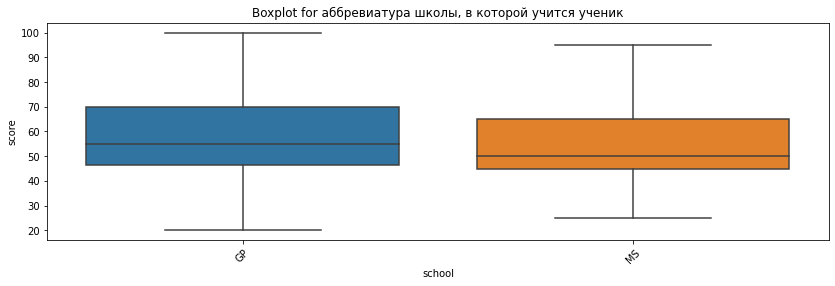

[('GP', 'MS')] 1
0.18190427233909176
0.18190427233909176
Найдены статистически значимые различия для колонки school


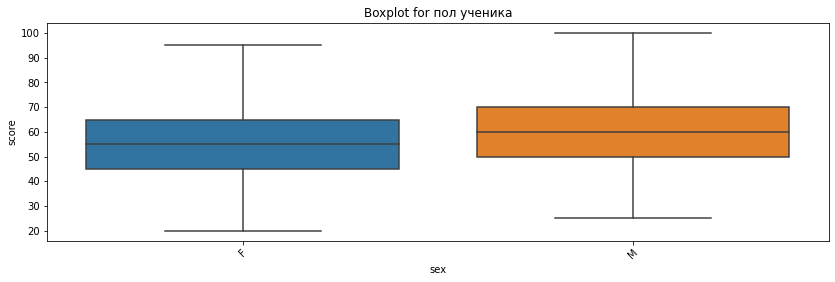

[('F', 'M')] 1
0.039263010361300865
Найдены статистически значимые различия для колонки sex
0.039263010361300865
Найдены статистически значимые различия для колонки sex


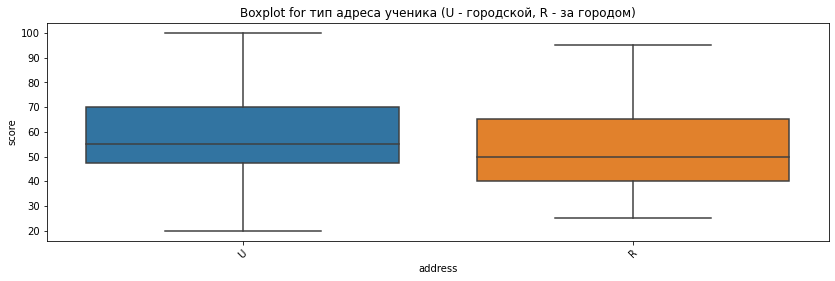

[('U', 'R')] 1
0.011554810366829768
Найдены статистически значимые различия для колонки address
0.011554810366829768
Найдены статистически значимые различия для колонки address


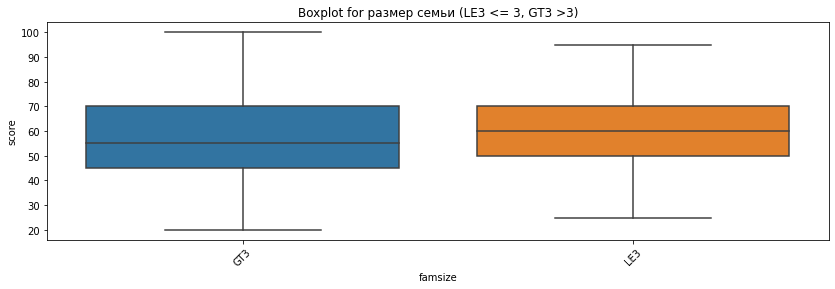

[('GT3', 'LE3')] 1
0.5541703346534932
0.5541703346534932
0.6774156697909539
0.4911065805405377


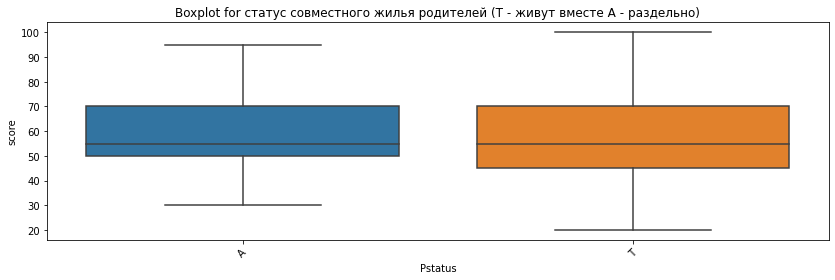

[('T', 'A')] 1
0.6386369549694808
0.5415202932011269
0.6386369549694808
0.9540375073167756


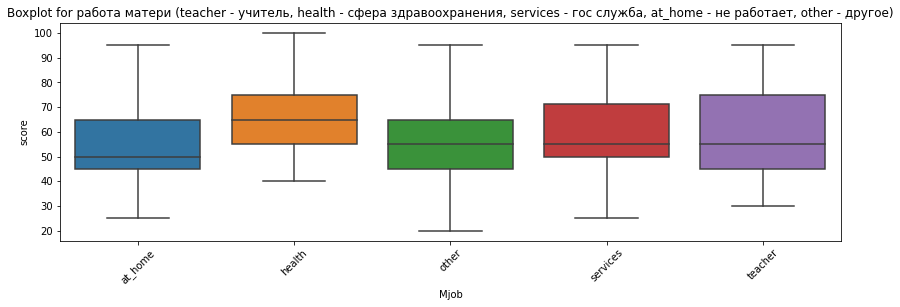

[('other', 'services'), ('other', 'teacher'), ('other', 'at_home'), ('other', 'health'), ('services', 'teacher'), ('services', 'at_home'), ('services', 'health'), ('teacher', 'at_home'), ('teacher', 'health'), ('at_home', 'health')] 10
0.03567260764444081
0.07190750168941776
0.8121796229807234
0.0017949217915780725
Найдены статистически значимые различия для колонки Mjob
0.03567260764444081
0.07190750168941776
0.8121796229807234
0.0017949217915780725
Найдены статистически значимые различия для колонки Mjob


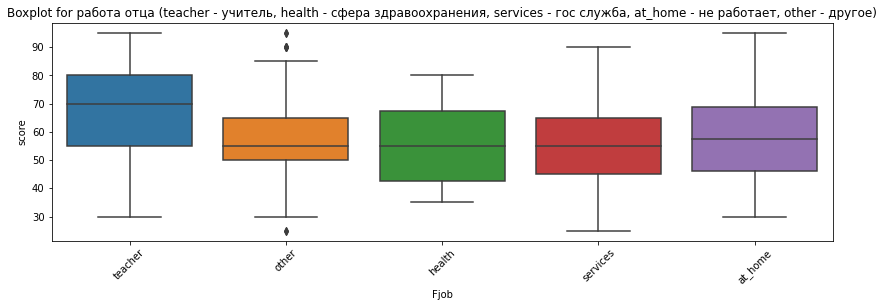

[('other', 'services'), ('other', 'teacher'), ('other', 'health'), ('other', 'at_home'), ('services', 'teacher'), ('services', 'health'), ('services', 'at_home'), ('teacher', 'health'), ('teacher', 'at_home'), ('health', 'at_home')] 10
0.8271066640344048
0.006250961128032644
0.8059154642103639
0.5430666319612605
0.006130722935239836
0.884332336427415
0.47303600892337483
0.0816859242785117
0.28357615621053667
0.5513579558649909
0.8271066640344048
0.14777807598419865
0.006250961128032644
Найдены статистически значимые различия для колонки Fjob


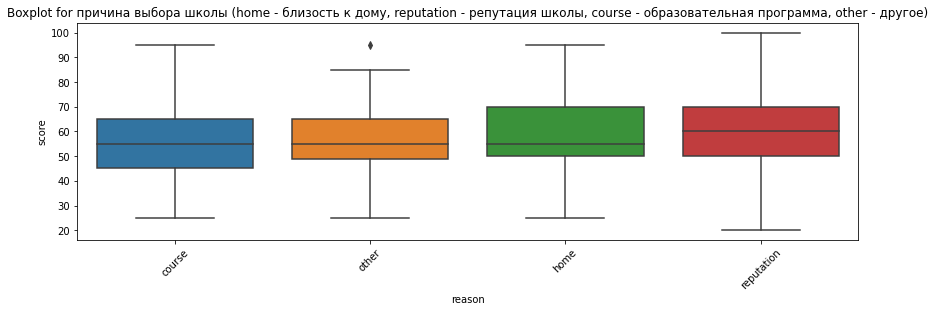

[('course', 'reputation'), ('course', 'home'), ('course', 'other'), ('reputation', 'home'), ('reputation', 'other'), ('home', 'other')] 6
0.2728811076640157
0.5099564406235139
0.973400679630223
0.669413149234061
0.48648046102657183
0.6742353229951893
0.2728811076640157
0.5099564406235139
0.973400679630223
0.8700580476499321
0.669413149234061
0.48648046102657183
0.7006315206987914
0.6742353229951893
0.8607137386003983
0.9020155483646648


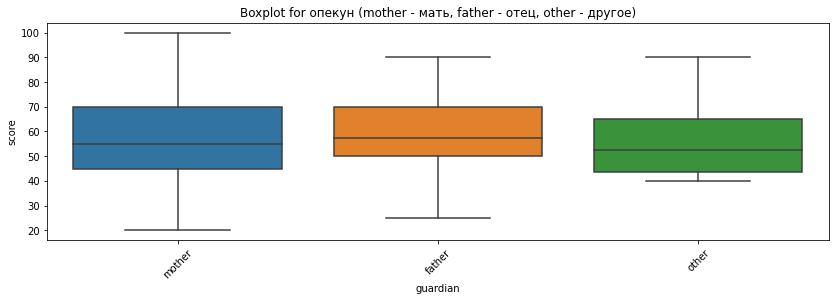

[('mother', 'father'), ('mother', 'other'), ('father', 'other')] 3
0.6316953581543334
0.430505896345
0.2773071542197519
0.6316953581543334
0.45226321507644873
0.430505896345
0.2698065366382698
0.2773071542197519
0.8688036068336635


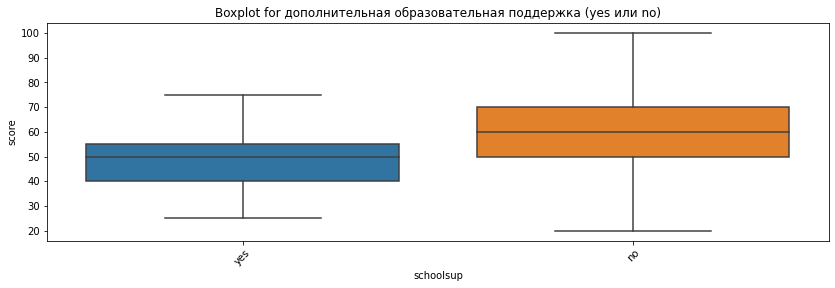

[('no', 'yes')] 1
5.804060500052466e-07
Найдены статистически значимые различия для колонки schoolsup
5.804060500052466e-07
Найдены статистически значимые различия для колонки schoolsup


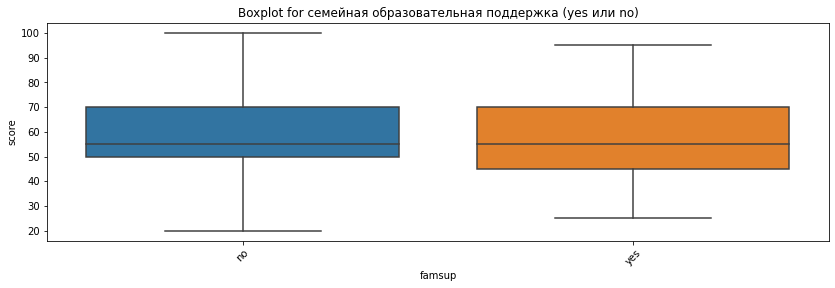

[('yes', 'no')] 1
0.4254397565406244
0.4254397565406244
0.6431109755302009
0.9586108146761279


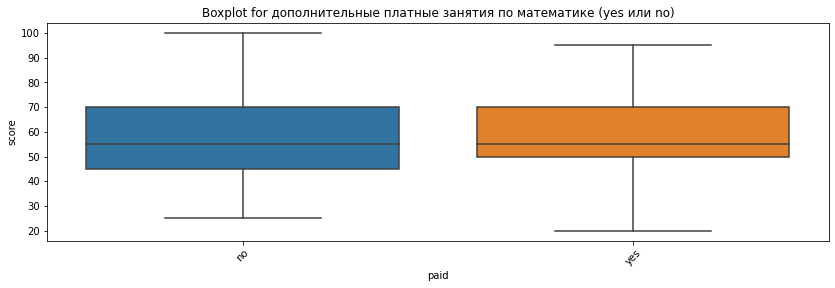

[('no', 'yes')] 1
0.7975264902507497
0.7975264902507497
0.365911727616547
0.42702005580409375


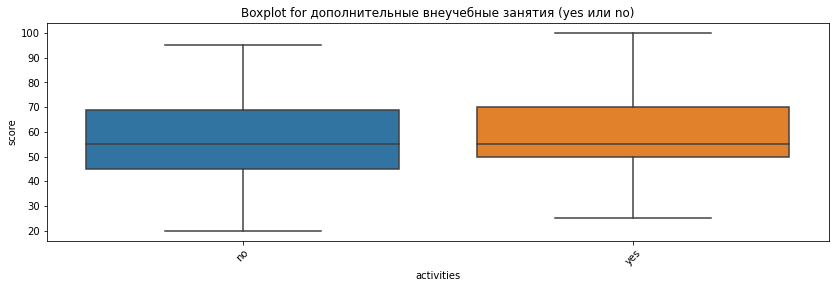

[('yes', 'no')] 1
0.24703733780193132
0.24703733780193132
0.4722337545537951
0.7849400253480238


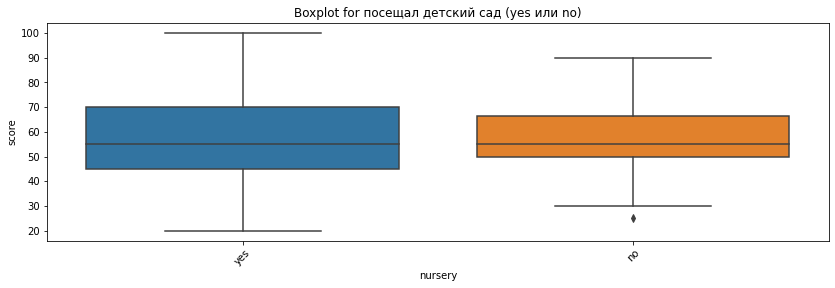

[('yes', 'no')] 1
0.5989349723281339
0.5989349723281339
0.3380426410113231
0.1822278848437713


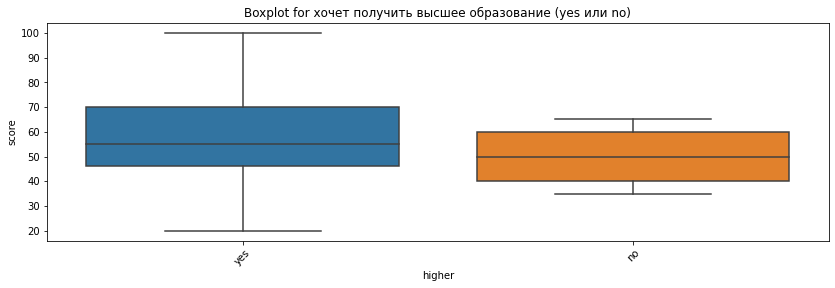

[('yes', 'no')] 1
0.056774907210764114
0.9744884469724967
0.056774907210764114
Найдены статистически значимые различия для колонки higher


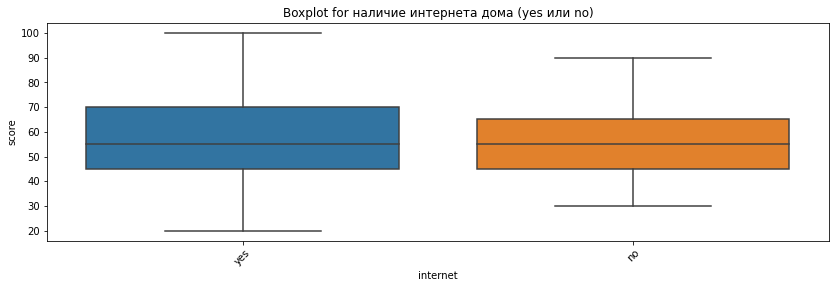

[('yes', 'no')] 1
0.27692956112946837
0.27692956112946837
0.9034553825471583
0.39186681974083004


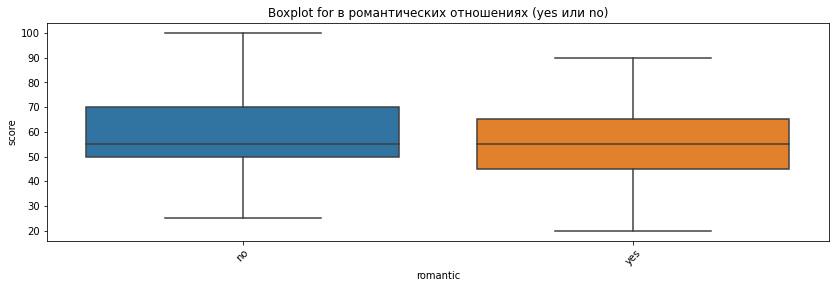

[('no', 'yes')] 1
0.2798681929382542
0.2798681929382542
0.5560824110994783
0.9594023095105004


In [10]:
for i in stud.columns:
    if (stud[i].dtype=='object'):
        kol_now = pd.DataFrame()
        kol_now[i]=stud[i] # значения текущей колонки
        kol_now['score']=stud['score']
        kol_now=kol_now[kol_now[i]!='None'] # значения текущей колонки без пропусков
        graf_boxplot(kol_now,str(i))
        
        # теста Стьюдента для данных без пропусков
        cols = kol_now.loc[:, i].value_counts().index[:10]
        combinations_all = list(combinations(cols, 2))
        print(combinations_all,len(combinations_all))
        for comb in combinations_all:
            print(ttest_ind(stud.loc[stud.loc[:, i] == comb[0], 'score'],stud.loc[stud.loc[:, i] == comb[1], 'score']).pvalue)
            if ttest_ind(kol_now.loc[kol_now.loc[:, i] == comb[0], 'score'],
                         kol_now.loc[kol_now.loc[:, i] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): 
                print('Найдены статистически значимые различия для колонки', i)
                break
                
        # теста Стьюдента для данных с пропусками
        cols = stud.loc[:, i].value_counts().index[:10]
        combinations_all = list(combinations(cols, 2))
        #print(combinations_all,len(combinations_all))
        for comb in combinations_all:
            print(ttest_ind(stud.loc[stud.loc[:, i] == comb[0], 'score'],stud.loc[stud.loc[:, i] == comb[1], 'score']).pvalue)
            if ttest_ind(stud.loc[stud.loc[:, i] == comb[0], 'score'],
                         stud.loc[stud.loc[:, i] == comb[1], 'score']).pvalue \
            <= 0.5/len(combinations_all): 
                print('Найдены статистически значимые различия для колонки', i)
                break

# Выводы

- В колонках не много пустых значений, но они находятся в разных стрках. Так исключать все строки, имеющие хотя бы один пропуск не целесообразно. Полностью дублирующихся строк нет. Имеется столбец, которого нет в описании 'studytime, granular'.
- Имеются выбросы в столбцах: Fedu — образование отца, absences — количество пропущенных занятий. Слишком мало данных об учениках старше 20 лет.
- Для численных данных самая высокая корреляция существует между характеристиками Medu - Fedu (уровень образование отца и матери) Kor: 0.595. Сильно коррелированных характеристик не наблюдается. 
    
    score (баллы по госэкзамену по математике) имеет положительную корреляцию с:
    Medu — образование матери - score Kor: 0.204; 
    studytime — время на учёбу помимо школы в неделю - score Kor: 0.088; 
    Fedu — образование отца - score Kor: 0.081; 
    famrel — семейные отношения - score Kor: 0.034,
    
    отрицательную корреляцию с:
    failures — количество внеучебных неудач - score Kor: -0.284; 
    absences — количество пропущенных занятий - score Kor: -0.221; 
    goout — проведение времени с друзьями - score Kor: -0.132; 
    age — возраст ученика - score Kor: -0.125; 
    traveltime — время в пути до школы - score Kor: -0.057; 
    freetime — свободное время после школы - score Kor: -0.043; 
    health — текущее состояние здоровья - score Kor: -0.025. 

- Для номинативных данных (по критерию 0.05) найдены статистически значимые различия для колонок: 
    sex — пол ученика; 
    address — тип адреса ученика; 
    Mjob — работа матери; 
    schoolsup — дополнительная образовательная поддержка.


In [251]:
conda install -c conda-forge jupyter_contrib_nbextensions


Note: you may need to restart the kernel to use updated packages.Collecting package metadata (current_repodata.json): ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Tomheten\anaconda3

  added / updated specs:
    - jupyter_contrib_nbextensions


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    jupyter_contrib_core-0.3.3 |             py_2          15 KB  conda-forge
    jupyter_contrib_nbextensions-0.5.1|   py38h32f6830_1        19.4 MB  conda-forge
    jupyter_highlight_selected_word-0.2.0|py38h32f6830_1002          15 KB  conda-forge
    jupyter_latex_envs-1.4.6   |py38h32f6830_1001         753 KB  conda-forge
    jupyter_nbextensions_configurator-0.4.1|   py38h32f6830_2         491 KB  conda-forge
    python_abi-3.8             |           1_



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda





  python_abi         conda-forge/win-64::python_abi-3.8-1_cp38

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py38_0 --> conda-forge::conda-4.9.2-py38haa244fe_0




jupyter_highlight_se | 15 KB     |            |   0% 
jupyter_highlight_se | 15 KB     | ########## | 100% 

conda-4.9.2          | 3.1 MB    |            |   0% 
conda-4.9.2          | 3.1 MB    | 5          |   6% 
conda-4.9.2          | 3.1 MB    | ###        |  30% 
conda-4.9.2          | 3.1 MB    | #####3     |  54% 
conda-4.9.2          | 3.1 MB    | ########3  |  83% 
conda-4.9.2          | 3.1 MB    | ########## | 100% 

jupyter_contrib_core | 15 KB     |            |   0% 
jupyter_contrib_core | 15 KB     | ########## | 100% 

jupyter_nbextensions | 491 KB    |            |   0% 
jupyter_nbextensions | 491 KB    | ########4  |  85% 
jupyter_nbextensions | 491 KB    | ########## | 100% 

jupyter_latex_envs-1 | 753 KB    |            |   0% 
jupyter_latex_envs-1 | 753

In [252]:
pip install autopep8

Note: you may need to restart the kernel to use updated packages.
